In [1]:
import seaborn as sns
sns.set_style("darkgrid")
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import copy
from scipy.stats import norm, t

In [2]:
portfolio = ["AAPL", "GOOGL", "BABA", "BIDU","C"]
quantity = [100, 10, 300, 100, 800]
df = pd.DataFrame()
for stock in portfolio:
    temp = pd.DataFrame(yf.download(stock, period = "1y")["Adj Close"])
    temp.columns = [f"{stock}"]
    df = pd.concat([df, temp], axis = 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df.tail()

,AAPL,GOOGL,BABA,BIDU,C
Date,,,,,
2023-09-21 00:00:00-04:00,173.929993,130.440002,84.110001,128.000000,41.709999
2023-09-22 00:00:00-04:00,174.789993,130.250000,88.300003,132.350006,40.919998
2023-09-25 00:00:00-04:00,176.080002,131.110001,87.220001,132.050003,41.020000
2023-09-26 00:00:00-04:00,171.960007,128.570007,85.910004,131.009995,40.220001
2023-09-27 00:00:00-04:00,170.429993,130.539993,86.190002,131.529999,40.459999


In [4]:
returns = df.pct_change()
time = len(returns)
meanReturns = returns.mean()
covMatrix = returns.cov()
print(f"Length of returns: {len(returns)}")
print("The mean returns:\n", meanReturns)
print("The covariance matrix:\n", covMatrix)

Length of returns: 251
The mean returns:
 AAPL     0.000695
GOOGL    0.001294
BABA     0.000753
BIDU     0.000900
C        0.000043
dtype: float64
The covariance matrix:
            AAPL     GOOGL      BABA      BIDU         C
AAPL   0.000316  0.000250  0.000143  0.000182  0.000128
GOOGL  0.000250  0.000461  0.000161  0.000272  0.000130
BABA   0.000143  0.000161  0.001027  0.000807  0.000174
BIDU   0.000182  0.000272  0.000807  0.001173  0.000171
C      0.000128  0.000130  0.000174  0.000171  0.000299


In [5]:
# quantity = [100, 10, 300, 100, 800]
weightage = np.multiply(quantity, df.iloc[-1]) / np.multiply(quantity, df.iloc[-1]).sum()
portfolioValue = np.multiply(quantity, df.iloc[-1]).sum()
portfolioMeanReturn = np.sum(meanReturns* weightage)
portfolioStdDeviation = np.sqrt(np.dot(weightage.T, np.dot(covMatrix, weightage)))

print(f"The portfolio mean return is {portfolioMeanReturn} over a period of {time} days")
print(f"The portfolio standard deviation is {portfolioStdDeviation}% over a period of {time} days")
print(f"The portfolio value is ${portfolioValue:.2f}")
print("\n")
print(f"The weightage of {portfolio} is \n\n{weightage}")

The portfolio mean return is 0.0005153053493229349 over a period of 251 days
The portfolio standard deviation is 0.018220284221898402% over a period of 251 days
The portfolio value is $89726.40


The weightage of ['AAPL', 'GOOGL', 'BABA', 'BIDU', 'C'] is 

AAPL     0.189944
GOOGL    0.014549
BABA     0.288176
BIDU     0.146590
C        0.360741
Name: 2023-09-27 00:00:00-04:00, dtype: float64


The historical return at 95% is -2.727%


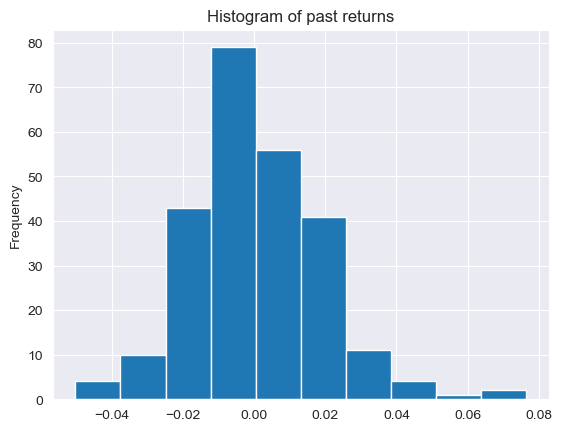

In [6]:
pnl = (weightage * returns).sum(axis = 1)
alpha = 5 #confidence level
historical_var = np.percentile(pnl, 5)
print(f"The historical return at {100-alpha}% is {historical_var*100:.3f}%")
pnl.plot(kind="hist", title = "Histogram of past returns")
plt.show()

In [7]:
# Normal Distribution has 0 skew and kurtosis of 3 but scipy will deduct 3, so we should be getting 0 
# for normal distribution
print(f"Skew is {skew(pnl)}")
print(f"Kurtosis is {kurtosis(pnl)}")

Skew is 0.5443295340002843
Kurtosis is 1.4420387877697491


<center><h3> Bootstrap VaR<center>

<font size = "3">Bootstrapping entails sampling the returns many times <b>with replacement</b>, returning the sampled return to the pot of returns each time for sampling again. We will sample x times, each with 1 year of returns, and getting the average of these x VaR at 95% confidence level<font>

In [8]:
#create function to sample returns
def var_x(data, alpha):
    """returns the value at risk for at 1-alpha confidence level"""
    return np.percentile(data, alpha)

#function to generate x random samples with replacement
def getVaR_samples_bootstrap(data, x, alpha):
    """return the average VaR from data at 1-alpha confidence level"""
    sample = np.empty(x)
    for i in range(x):
        # get a sample with replacement
        temp = np.random.choice(data, len(data)) # with replacement
        sample[i] = np.percentile(temp, alpha)
    return np.mean(sample)

In [9]:
bootstrap_VaR = getVaR_samples_bootstrap(pnl, 10000, 5)
print(f"The Bootstrap VaR is {bootstrap_VaR*100:.3f}%")

The Bootstrap VaR is -2.671%


<p style="text-align: center;"> <b> <font size = "5"> Applying a decay factor to returns to calculate age-weighted VaR</font></b>.</p>

<center> <font size = "3"><b>Formula for weight on day i: </b></font><center>
<br>
$$
\frac{\lambda^{i-1}(1-\lambda)}{1 - \lambda ^ n}
$$

In [10]:
lambd = 0.94
n = len(pnl)
dailyWeightage  = [(lambd**(i-1) * (1-lambd))/ (1 - lambd ** n) for i in range(1,n+1)]
sum(dailyWeightage) # sense check

0.9999999999999998

In [11]:
pnl_reverse = pnl[::-1]
weighted_returns = pd.DataFrame({"dailyReturns": pnl_reverse, "dailyWeightage": dailyWeightage})
weighted_returns_sorted = weighted_returns.sort_values(by="dailyReturns")
weighted_returns_sorted["weightcum"] = weighted_returns_sorted.dailyWeightage.cumsum()
weighted_returns_sorted

,dailyReturns,dailyWeightage,weightcum
Date,,,
2022-10-24 00:00:00-04:00,-0.050264,3.497948e-08,3.497948e-08
2022-12-15 00:00:00-05:00,-0.041900,3.452095e-07,3.801890e-07
2023-03-09 00:00:00-05:00,-0.040778,1.103883e-05,1.141902e-05
2022-10-19 00:00:00-04:00,-0.038703,2.905340e-08,1.144807e-05
2022-11-09 00:00:00-05:00,-0.036249,7.349861e-08,1.152157e-05
...,...,...,...
2022-11-15 00:00:00-05:00,0.048168,9.413859e-08,9.999743e-01
2023-03-28 00:00:00-04:00,0.050616,2.467521e-05,9.999990e-01
2022-11-30 00:00:00-05:00,0.057454,1.747790e-07,9.999992e-01


In [12]:
weighted_returns_sorted.reset_index(inplace=True)
first_occurence = weighted_returns_sorted[weighted_returns_sorted["weightcum"] <= 0.05]["dailyReturns"].idxmax()
var_weighted = weighted_returns_sorted.loc[first_occurence, "dailyReturns"]
print(f"The age-weighted VaR with lambda factor of {lambd} is {var_weighted*100:.3f}%")
weighted_returns_sorted.loc[first_occurence:first_occurence+1:]

The age-weighted VaR with lambda factor of 0.94 is -1.780%


,Date,dailyReturns,dailyWeightage,weightcum
35,2022-11-16 00:00:00-05:00,-0.017799,1.001474e-07,0.045100
36,2023-08-15 00:00:00-04:00,-0.017743,9.375338e-03,0.054475


<font size = "4"><center>We can also do interpolation between the 2 rows that pass our 5%<font>

In [13]:
x_values = weighted_returns_sorted.loc[first_occurence:first_occurence+1, "weightcum"]
y_values = weighted_returns_sorted.loc[first_occurence:first_occurence+1, "dailyReturns"]
interp_VaR = np.interp(0.05, x_values, y_values)
print(f"The age-weighted VaR with lambda factor of {lambd} interpolated at 5% is {interp_VaR*100:.3f}%")

The age-weighted VaR with lambda factor of 0.94 interpolated at 5% is -1.777%


<p style="text-align: center;"> <b> <font size = "5"> Using Volatility-Weighted VaR</font></b>.</p>

<font size = "4">This method of computation adjusts VaR by its most recent volatility according to the equation below:<f>
$$
r'_{t,i} = (\frac{\sigma_{T,i}}{\sigma_{t,i}})r_{t,i}
$$
<font size = "4">So if volatility in the past was only 1%, and today is 5%, this model will bump up the returns accordingly to give a heavier weightage to recent returns.<f>

In [14]:
from arch import arch_model

In [15]:
vol_garch = pd.DataFrame(index = returns.index)
# returns = returns * 100 # to scale up by 100 times to prevent convergence issue with arch model
for stock in returns:
    am = arch_model(returns[stock].dropna() * 100) #multply returns by 100 to prevent convergence issue with arch model
    res = am.fit(disp = "off")
    vol_garch[stock+"GARCHVol"] = res.conditional_volatility

In [16]:
vol_garch.tail()

,AAPLGARCHVol,GOOGLGARCHVol,BABAGARCHVol,BIDUGARCHVol,CGARCHVol
Date,,,,,
2023-09-21 00:00:00-04:00,1.236223,1.495874,2.212034,2.220968,1.471775
2023-09-22 00:00:00-04:00,1.235766,1.492440,2.206957,2.218284,1.503268
2023-09-25 00:00:00-04:00,1.235316,1.489014,2.201892,2.227667,1.580186
2023-09-26 00:00:00-04:00,1.234875,1.485595,2.196838,2.209717,1.517838
2023-09-27 00:00:00-04:00,1.234442,1.482185,2.191796,2.193532,1.597329


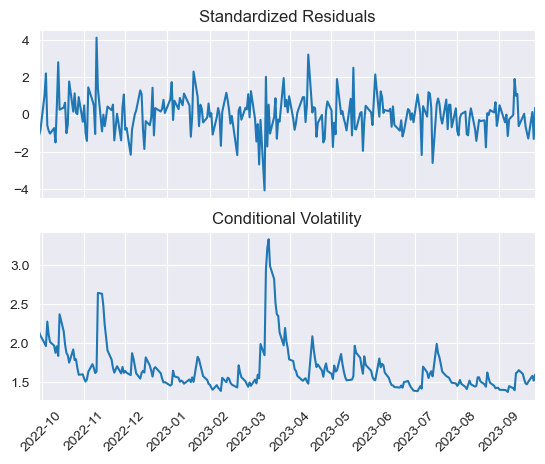

In [17]:
fig = res.plot()
plt.xticks(rotation = 45)
plt.show()

In [18]:
vol_garch_adjusted = copy.deepcopy(vol_garch)
for stock in vol_garch_adjusted:
    #whole column divided by most recent garch adjusted vol
    vol_garch_adjusted[stock] = vol_garch_adjusted[stock].apply(lambda x: vol_garch_adjusted[stock][-1] / x) 
vol_garch_adjusted

,AAPLGARCHVol,GOOGLGARCHVol,BABAGARCHVol,BIDUGARCHVol,CGARCHVol
Date,,,,,
2022-09-28 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN
2022-09-29 00:00:00-04:00,0.447072,0.564230,0.564304,0.554955,0.746856
2022-09-30 00:00:00-04:00,0.450484,0.565529,0.565603,0.557608,0.762724
2022-10-03 00:00:00-04:00,0.453909,0.566830,0.566904,0.562178,0.799789
2022-10-04 00:00:00-04:00,0.457347,0.568134,0.568208,0.566253,0.814733
...,...,...,...,...,...
2023-09-21 00:00:00-04:00,0.998559,0.990849,0.990851,0.987647,1.085308
2023-09-22 00:00:00-04:00,0.998929,0.993129,0.993130,0.988842,1.062571
2023-09-25 00:00:00-04:00,0.999292,0.995414,0.995415,0.984677,1.010849


In [19]:
vol_adj_portfolio = pd.DataFrame(returns.values * vol_garch_adjusted.values, columns = returns.columns, 
                                 index = returns.index)
vol_adj_portfolio

,AAPL,GOOGL,BABA,BIDU,C
Date,,,,,
2022-09-28 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN
2022-09-29 00:00:00-04:00,-0.021960,-0.014832,-0.013447,-0.016822,-0.017381
2022-09-30 00:00:00-04:00,-0.013532,-0.010275,0.006653,-0.001089,-0.012955
2022-10-03 00:00:00-04:00,0.013959,0.017719,0.003260,0.009522,0.017082
2022-10-04 00:00:00-04:00,0.011719,0.017279,0.025850,0.018104,0.035415
...,...,...,...,...,...
2023-09-21 00:00:00-04:00,-0.008877,-0.024449,-0.018837,-0.023942,-0.015138
2023-09-22 00:00:00-04:00,0.004939,-0.001447,0.049474,0.033605,-0.020125
2023-09-25 00:00:00-04:00,0.007375,0.006572,-0.012175,-0.002232,0.002470


In [20]:
vol_adjusted_returns = (weightage * vol_adj_portfolio).sum(axis = 1)
VaR_Vol_Weighted = np.percentile(vol_adjusted_returns, 5, method="lower")
print(f"The volatility weighted historical VaR is {VaR_Vol_Weighted*100:.3f}%")

The volatility weighted historical VaR is -2.045%


<center><h2>Parametric VaR</h2></center>
<br>
<font size = "4">Make an assumption on the distribution of returns and use historical portfolio performance and standard deviations to define parameters for the model. 2 parametric VaR models are used below:

   
<ul>
    <li>Normal Distribution</li>
    <li>t-Distribution (fatter distribution)</li>         
</ul>
<f> 

In [21]:
def var_parametric(portfolioReturns, portfolioStd, distribution="normal", alpha=5, dof=6):
    """Only for normal distribution or t-distribution"""
    if distribution == "normal":
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portfolioReturns
    elif distribution == "t-distribution":
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portfolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portfolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == "normal":
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portfolioReturns
    elif distribution == "t-distribution":
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portfolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [22]:
normVaR = var_parametric(portfolioMeanReturn, portfolioStdDeviation)
normCVaR = cvar_parametric(portfolioMeanReturn, portfolioStdDeviation)

tVaR = var_parametric(portfolioMeanReturn, portfolioStdDeviation, distribution='t-distribution')
tCVaR = cvar_parametric(portfolioMeanReturn, portfolioStdDeviation, distribution='t-distribution')

print(f"Normal VaR 95th CI       :      {normVaR*100:.3f}%")
print(f"Normal CVaR 95th CI      :      {normCVaR*100:.3f}%")
print(f"t-dist VaR 95th CI       :      {tVaR*100:.3f}%")
print(f"t-dist CVaR 95th CI      :      {tCVaR*100:.3f}%")

Normal VaR 95th CI       :      2.945%
Normal CVaR 95th CI      :      3.707%
t-dist VaR 95th CI       :      2.839%
t-dist CVaR 95th CI      :      3.877%


<center><h2>Monte Carlo VaR and CVaR</h2></center>
<font size = "4"> Using a Monte Carlo (MC) simulation of the entire stock portfolio to calculate the VaR measures</f>

In [23]:
mcSims=400 # number of simulations
T = 1 # number of day/s
meanM = np.full(shape=(T, len(weightage)), fill_value=meanReturns)
meanM = meanM.T
portfolioValueArray = np.full(shape=(1,mcSims), fill_value=portfolioValue)

portfolio_sims = np.full(shape=(T, mcSims), fill_value=0.0)

for i in range(0, mcSims):
    Z = np.random.normal(size=(T, len(weightage)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:, i] = np.cumprod(np.inner(weightage, dailyReturns.T)+1) * portfolioValue
portfolio_sims = np.vstack((portfolioValueArray, portfolio_sims))

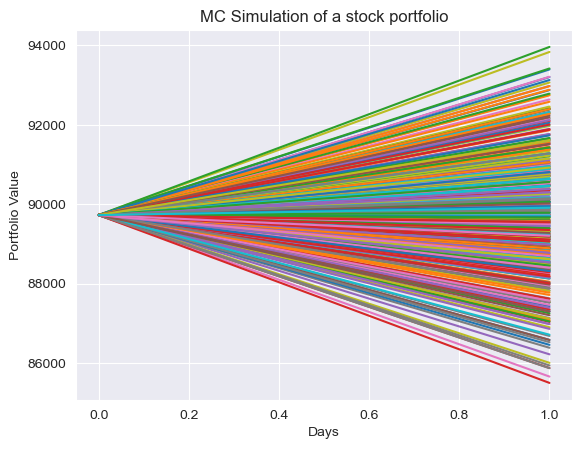

In [24]:
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value")
plt.xlabel("Days")
plt.title("MC Simulation of a stock portfolio")
plt.show()

In [25]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [26]:
portResults = pd.Series(portfolio_sims[-1,:])
VaR = portfolioValue - mcVaR(portResults, alpha=5)
CVaR = portfolioValue - mcCVaR(portResults, alpha=5)
print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))
print(f"The MC Var is {VaR/portfolioValue*100:.2f}%")

VaR $2659.67
CVaR $3286.47
The MC Var is 2.96%


In [27]:
# For reference
# b = np.array([[1,2],
#               [2,3]])
# a = np.array([
#          [3,4],
#          [5,6]])
# print(np.dot(b, a))
# print(np.inner(b,a.T))
# print(np.matmul(b,a))